### **Image Colorization**

Utilized the model as described by Richard Zhang

https://github.com/richzhang/colorization

In [ ]:
import torch
from torch import nn

class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm

In [ ]:

import torch
import torch.nn as nn
import numpy as np
from IPython import embed

class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))


In [ ]:

from PIL import Image
import numpy as np
from skimage import color
import torch
import torch.nn.functional as F
from IPython import embed

def load_img(img_path):
	out_np = np.asarray(Image.open(img_path))
	if(out_np.ndim==2):
		out_np = np.tile(out_np[:,:,None],3)
	return out_np

def resize_img(img, HW=(256,256), resample=3):
	return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

def preprocess_img(img_rgb_orig, HW=(256,256), resample=3):
	# return original size L and resized L as torch Tensors
	img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)
	
	img_lab_orig = color.rgb2lab(img_rgb_orig)
	img_lab_rs = color.rgb2lab(img_rgb_rs)

	img_l_orig = img_lab_orig[:,:,0]
	img_l_rs = img_lab_rs[:,:,0]

	tens_orig_l = torch.Tensor(img_l_orig)[None,None,:,:]
	tens_rs_l = torch.Tensor(img_l_rs)[None,None,:,:]

	return (tens_orig_l, tens_rs_l)

def postprocess_tens(tens_orig_l, out_ab, mode='bilinear'):
	# tens_orig_l 	1 x 1 x H_orig x W_orig
	# out_ab 		1 x 2 x H x W

	HW_orig = tens_orig_l.shape[2:]
	HW = out_ab.shape[2:]

	# call resize function if needed
	if(HW_orig[0]!=HW[0] or HW_orig[1]!=HW[1]):
		out_ab_orig = F.interpolate(out_ab, size=HW_orig, mode='bilinear')
	else:
		out_ab_orig = out_ab

	out_lab_orig = torch.cat((tens_orig_l, out_ab_orig), dim=1)
	return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))

(-0.5, 2047.5, 1151.5, -0.5)

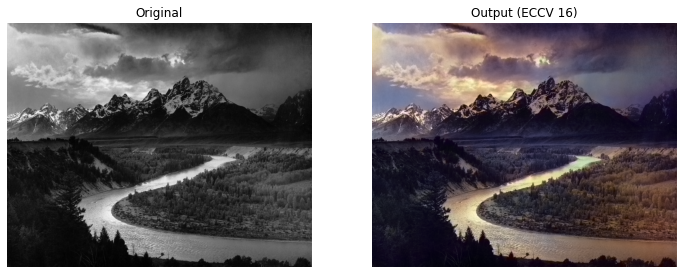

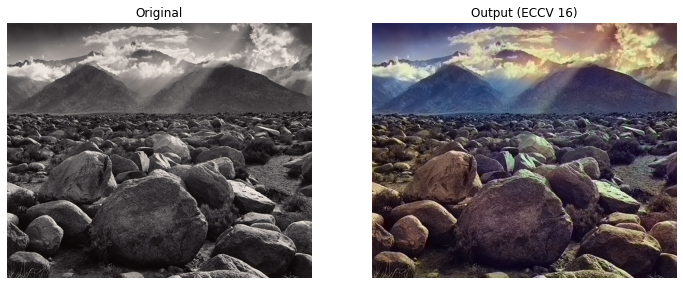

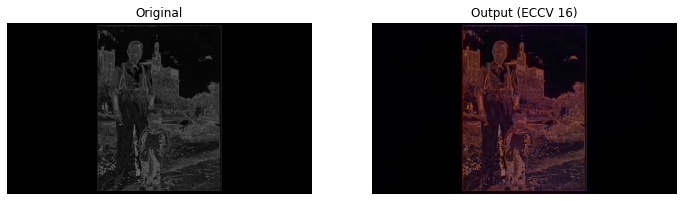

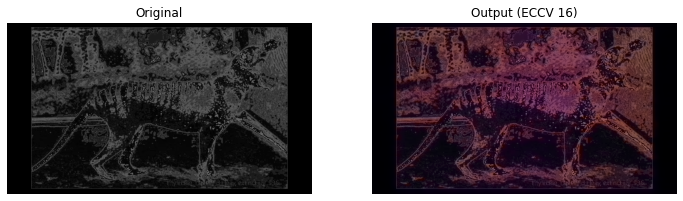

In [ ]:

import argparse
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms

# load colorizers
colorizer_eccv16 = eccv16(pretrained=True).eval()

# default size to process images is 256x256
# grab L channel in both original ("orig") and resized ("rs") resolutions
img = load_img("/content/ansel_adams.jpg")
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))

# colorizer outputs 256x256 ab map
# resize and concatenate to original L channel
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
out_img_eccv16 = postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(out_img_eccv16)
plt.title('Output (ECCV 16)')
plt.axis('off')

img = load_img("/content/ansel_adams2.jpg")
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))

# colorizer outputs 256x256 ab map
# resize and concatenate to original L channel
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
out_img_eccv16 = postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(out_img_eccv16)
plt.title('Output (ECCV 16)')
plt.axis('off')

img = load_img("/content/qSTc2T85 (1).png")
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))

# colorizer outputs 256x256 ab map
# resize and concatenate to original L channel
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
out_img_eccv16 = postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(out_img_eccv16)
plt.title('Output (ECCV 16)')
plt.axis('off')

img = load_img("/content/qSTc2T85.png")
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))

# colorizer outputs 256x256 ab map
# resize and concatenate to original L channel
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
out_img_eccv16 = postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(out_img_eccv16)
plt.title('Output (ECCV 16)')
plt.axis('off')

